# ECG-Pytorch-Ver2.0

@create 2021-09-13
@author 孙寒石
@env Pytorch 1.9.0 Python 3.7

## Import Packages

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Prepare Dataset

In [2]:
import os
import scipy.io as scio
from sklearn.model_selection import train_test_split

base_path = './'
dataset_path =  './Dataset' # Training data

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        data_train = scio.loadmat(os.path.join(root, name))# 取出字典里的value
        
        # arr -> list
        data_arr = data_train.get('val')
        data_list = data_arr.tolist()
        
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 1)  # name -> num
        
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
        
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma
    
X=np.array(X)
y=np.array(y)
X = standardization(X)
X = X.reshape((1000,1,3600))
y = y.reshape((1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))

X_train :  800
X_test  :  200
shape of X_train :  (1, 3600)
shape of y_train :  (800,)
shape of X_test :  (200, 1, 3600)
shape of y_test :  (200,)


In [3]:
batch_size = 16
class MyDataset(Dataset):
    def __init__(self):
        self.len = X_train.shape[0] # 取第0元素：长度
        self.x_train = torch.from_numpy(X_train).float().to("cuda")
        self.y_train = torch.from_numpy(y_train).long().to("cuda")
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index] # 返回对应样本即可
    def __len__(self):
        return self.len
    
class TestDataset(Dataset):
    def __init__(self):
        self.len = X_test.shape[0] # 取第0元素：长度
        self.x_test = torch.from_numpy(X_test).float().to("cuda")
        self.y_test = torch.from_numpy(y_test).long().to("cuda")
    def __getitem__(self, index):
        return self.x_test[index], self.y_test[index] # 返回对应样本即可
    def __len__(self):
        return self.len    
        
train_dataset = MyDataset()
test_dataset = TestDataset()
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)
test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)

## Load Model

In [4]:
in_channels_ = 1
num_segments_in_record = 100
segment_len = 3600   # 3600 采样
num_classes = 17

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class arrhythmia_classifier(nn.Module):
    def __init__(self, in_channels=in_channels_):
        super(arrhythmia_classifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1,8,16,stride=2,padding=7),
            nn.ReLU(),
            #nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=8,stride=4),
   
            nn.Conv1d(8,12,12,padding=5,stride=2),
            nn.ReLU(),
            #nn.BatchNorm1d(16),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(12,32,9,stride=1,padding=4),
            nn.ReLU(),
            nn.MaxPool1d(5,stride=2),
            
            nn.Conv1d(32,64,7,stride=1,padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(64,64,5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(64,64,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(64,72,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            Flatten(),
            nn.Linear(in_features=216, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(in_features=64, out_features=17),
        )

    def forward(self, x, ex_features=None):
        return self.cnn(x)


def calc_next_len_conv1d(current_len=112500, kernel_size=16, stride=8, padding=0, dilation=1):
    return int(np.floor((current_len + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = arrhythmia_classifier().to(device)
from torchsummary import summary
summary(model, input_size=(1, 3600))

model = torch.load('test_1.pt',map_location='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 8, 1800]             136
              ReLU-2              [-1, 8, 1800]               0
         MaxPool1d-3               [-1, 8, 449]               0
            Conv1d-4              [-1, 12, 224]           1,164
              ReLU-5              [-1, 12, 224]               0
         MaxPool1d-6              [-1, 12, 111]               0
            Conv1d-7              [-1, 32, 111]           3,488
              ReLU-8              [-1, 32, 111]               0
         MaxPool1d-9               [-1, 32, 54]               0
           Conv1d-10               [-1, 64, 54]          14,400
             ReLU-11               [-1, 64, 54]               0
        MaxPool1d-12               [-1, 64, 26]               0
           Conv1d-13               [-1, 64, 26]          20,544
             ReLU-14               [-1,

/home/preminstrel/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
correct = 0
total = 0
with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            print(predicted)
            print(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
print('Accuracy on test set: %d %%' % (100 * correct / total))

tensor([13,  0,  6, 12,  6,  6, 16,  3,  0, 14,  6,  0, 14,  6,  7,  1],
       device='cuda:0')
tensor([13,  0,  6, 12,  6,  6, 16,  3,  0, 14,  6,  0, 14,  6,  7,  1],
       device='cuda:0')
tensor([ 0,  0,  0,  3,  3,  0, 14, 12,  0,  6,  0,  6,  7, 13, 16,  3],
       device='cuda:0')
tensor([ 0,  0,  0,  3,  3,  0, 14, 12,  0,  6,  0,  6,  7, 13, 16,  3],
       device='cuda:0')
tensor([ 3,  0, 14,  0,  3,  2,  6,  6,  7,  0, 15,  6,  1,  8,  6,  0],
       device='cuda:0')
tensor([ 3,  0, 14,  6,  3,  2,  6,  6,  7,  0, 15,  6,  1,  8,  6,  0],
       device='cuda:0')
tensor([ 6,  3,  0,  4,  0,  3, 13,  8,  3,  2,  1,  0,  0,  3,  6, 13],
       device='cuda:0')
tensor([ 6,  3,  0,  4,  0,  3, 13,  8,  3,  2,  1,  0,  0,  3,  6, 13],
       device='cuda:0')
tensor([ 6,  3, 12,  6,  3, 13, 13,  7,  0,  0,  6, 16, 16,  6, 14, 13],
       device='cuda:0')
tensor([ 6,  3, 12,  6,  3, 13, 13,  7,  0,  0,  6, 16,  9,  6, 14, 13],
       device='cuda:0')
tensor([ 0,  7,  6,  0,  6,  3

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = arrhythmia_classifier().to(device)
#model.load_state_dict(model_zoo.load_url(model_urls['ecgnet']))
#model.load_state_dict(copy.deepcopy(torch.load("/mnt/c/Users/12647/Desktop/BitSplit-master/models/test_2.pth",device)))
model = torch.load('test_2.pth')

In [7]:
model.modules

AttributeError: 'collections.OrderedDict' object has no attribute 'modules'

In [ ]:
model.cnn[0]

In [8]:
import argparse
import os
import scipy.io as scio
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import math
from torchvision import datasets, transforms 
import numpy as np

# Defining the network (ECGNet5)  
in_channels_ = 1
num_segments_in_record = 100
segment_len = 3600   # 3600 采样
num_classes = 17
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
        
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

class ECGNet(nn.Module):
    def __init__(self, in_channels=in_channels_):
        super(ECGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1,8,16,stride=2,padding=7),
            nn.ReLU(),
            #nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=8,stride=4),
   
            nn.Conv1d(8,12,12,padding=5,stride=2),
            nn.ReLU(),
            #nn.BatchNorm1d(16),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(12,32,9,stride=1,padding=4),
            nn.ReLU(),
            nn.MaxPool1d(5,stride=2),
            
            nn.Conv1d(32,64,7,stride=1,padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(64,64,5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(64,64,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(64,72,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
        )
        self.classifier = torch.nn.Sequential(
            nn.Linear(in_features=216, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(in_features=64, out_features=17),
        )

    def forward(self, x, ex_features=None):
        x = self.features(x)
        x = x.view((-1,216))
        x = self.classifier(x)
        return x

In [9]:
import torch
net = ECGNet().cuda()
checkpoint = torch.load('ECGNet_model_q.pth')
net.load_state_dict(checkpoint['net_state_dict'])

<All keys matched successfully>

In [10]:
net.features[0].weight

Parameter containing:
tensor([[[ 0.1555, -0.1555, -0.1555,  0.1555, -0.1555, -0.1555,  0.1555,
          -0.1555, -0.1555,  0.1555, -0.1555, -0.1555, -0.1555,  0.1555,
           0.1555, -0.1555]],

        [[ 0.1634,  0.1634,  0.1634,  0.1634,  0.1634,  0.1634, -0.1634,
           0.1634, -0.1634,  0.1634, -0.1634,  0.1634,  0.1634,  0.1634,
           0.1634, -0.1634]],

        [[ 0.1754,  0.1754,  0.1754,  0.1754,  0.1754,  0.1754, -0.1754,
           0.1754, -0.1754,  0.1754,  0.1754,  0.1754,  0.1754,  0.1754,
           0.1754, -0.1754]],

        [[ 0.1386, -0.1386,  0.1386,  0.1386,  0.1386, -0.1386, -0.1386,
           0.1386,  0.1386, -0.1386, -0.1386, -0.1386, -0.1386,  0.1386,
           0.1386,  0.1386]],

        [[-0.0311, -0.0311, -0.2602, -0.2602, -0.2602,  0.0311,  0.0311,
           0.2602, -0.0311, -0.0311, -0.0311,  0.2602,  0.2602, -0.0311,
           0.2602,  0.0311]],

        [[ 0.1844,  0.1844,  0.1844,  0.1844,  0.1844,  0.1844,  0.1844,
           0.1844,  

In [11]:
correct = 0
total = 0
with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, dim=1)
            print(predicted)
            print(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
print('Accuracy on test set: %d %%' % (100 * correct / total))

tensor([ 0,  0,  3,  3, 14, 14,  0,  3,  0,  0,  0,  0,  6, 10,  2,  3],
       device='cuda:0')
tensor([ 0,  0,  3,  3, 15, 14,  0,  3,  0,  0,  0,  0,  6, 10,  6,  3],
       device='cuda:0')
tensor([ 3,  1,  6,  6,  3,  6,  6,  3,  0,  5,  0,  0,  0,  6, 14,  2],
       device='cuda:0')
tensor([ 3,  1,  6,  6,  3,  7,  6,  3,  0,  5,  0,  0,  0,  6, 14,  2],
       device='cuda:0')
tensor([ 7,  3,  0, 11,  0, 14,  0, 13, 14, 12,  3,  3,  6,  2,  0,  0],
       device='cuda:0')
tensor([ 7,  3,  0,  4,  0, 14,  0, 13, 14, 12,  3,  3,  6,  2,  0,  0],
       device='cuda:0')
tensor([ 3,  3,  0,  3,  6,  8, 16,  1,  0,  0,  9,  3,  6,  0,  6,  0],
       device='cuda:0')
tensor([ 3,  3,  0,  3,  6,  8, 16,  1,  0,  0,  9,  3,  6,  0,  6,  0],
       device='cuda:0')
tensor([ 6,  6, 14,  6,  6, 13, 13,  3,  0,  4,  6, 14, 15,  2,  3,  6],
       device='cuda:0')
tensor([ 6,  6, 14,  6,  6, 13, 13,  3,  0,  4,  6, 14, 15,  2,  3,  6],
       device='cuda:0')
tensor([ 7,  3,  0,  0,  6,  0

Normalized confusion matrix
[[0.97844828 0.01724138 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.00431034 0.         0.        ]
 [0.03773585 0.96226415 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.07692308 0.92307692 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.01869159 0.96261682 0.00934579 0.
  0.         0.         0.00934579 0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.       

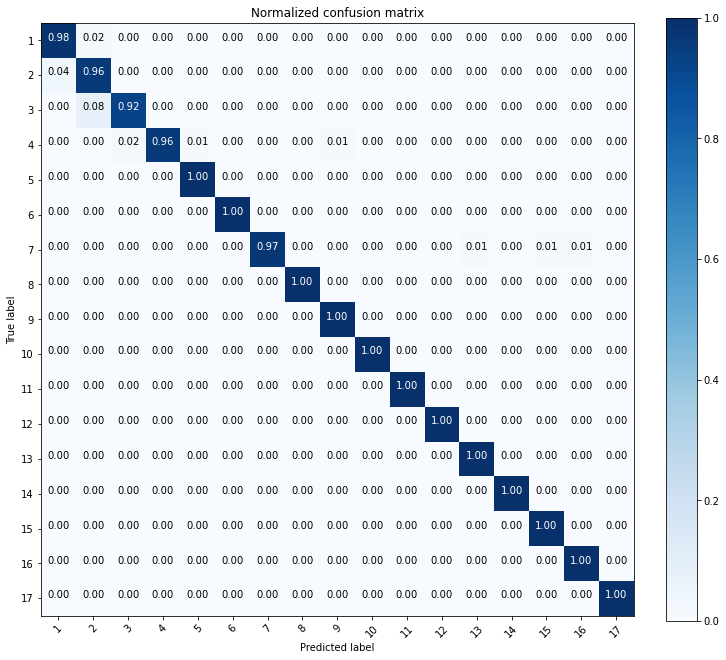

In [13]:
import itertools
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def confusion_matrix(preds, labels, conf_matrix):
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix
conf_matrix = torch.zeros(17, 17)
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        out = net(images)
        prediction = torch.max(out, 1)[1]
        conf_matrix = confusion_matrix(prediction, labels=labels, conf_matrix=conf_matrix)
attack_types=['1', '2', '3', '4', '5','6','7','8','9','10','11','12','13','14','15','16','17']
plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_matrix.numpy(), classes=attack_types, normalize=True, title='Normalized confusion matrix')